# NLP - QA Bot with Seq2seq Models
Taking a step away from MTG world, this notebook will try to train a QA Bot using a Sequence to Sequence (seq2seq) model. 

In [68]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input

## Dataset retrieval

In [69]:
import os
import gdown
if os.access('./other_datasets/data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = './other_datasets/data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("Dataset is already in the folder")

Dataset is already in the folder


In [70]:
# dataset_file
import json

text_file = './other_datasets/data_volunteers.json'
with open(text_file) as f:
    data = json.load(f)

In [71]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) has <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) has <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Amount of rows used", len(input_sentences))

Amount of rows used 6033


In [72]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

## Preprocessing

In [73]:
# Define a maximum amount of words to use as to reduce RAM consumption.
MAX_VOCAB_SIZE = 10000

### Input vectorizers and vocab

In [74]:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer

input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Words in input vocab", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Longest sentence in input corpus", max_input_len)

Words in input vocab 1799
Longest sentence in input corpus 9


### Output vectorizers and vocab

In [75]:
# Modify the filters to keep the <> characters
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Words in output vocab", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) 

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Longest sentence in output corpus", max_out_len)

Words in output vocab 1806
Longest sentence in output corpus 10


Encoder inputs have a prefix padding since only the last words are important.

In [76]:
print("Total dataset length:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Total dataset length: 6033
encoder_input_sequences shape: (6033, 9)
decoder_input_sequences shape: (6033, 10)


A softmax categorical output will be used, to output target must be in an OneHot format

In [77]:
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6033, 10, 1807)

In [78]:
decoder_output_sequences

array([[ 24,  10,   7, ...,   0,   0,   0],
       [ 28, 191,  31, ...,   0,   0,   0],
       [ 20,   1,   0, ...,   0,   0,   0],
       ...,
       [ 66, 184, 143, ...,   0,   0,   0],
       [  5,   4,   2, ...,   0,   0,   0],
       [  1,   0,   0, ...,   0,   0,   0]])

## Word Embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [79]:
import os
import gdown
if os.access('./other_datasets/gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = './other_datasets/gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("gloveembedding.pkl embeddings are already present")

gloveembedding.pkl embeddings are already present


In [80]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = './other_datasets/gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [81]:
model_embeddings = GloveEmbeddings()

In [82]:
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 38


In [83]:
embedding_matrix.shape

(1799, 50)

## Models
This model will be based in the encoder-decoder model, in which, for training, the input to the decoder is the hidden last state of the encoder plus the whole output sequence, predicting also the output sequences. 

For inference, only the decoder is used and the input of the model is the last hidden state of the encoder (given the input squence) for the first iteration, and then loop the decoder, where the input is the last predicted word and last decoder states, until the \<eos> (end of sequence) token is predicted.

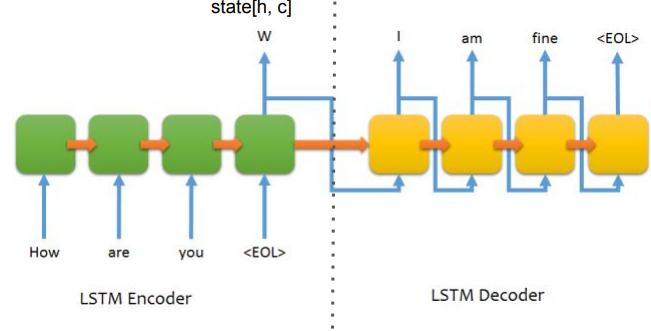

### Encoder-decoder model for training

In [84]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

n_units = 64

# define training encoder
encoder_inputs = Input(shape=(max_input_len))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,
          output_dim=embed_dim,
          input_length=max_input_len,
          weights=[embedding_matrix],
          trainable=False) 

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 9, 50)        89950       ['input_13[0][0]']               
                                                                                                  
 embedding_7 (Embedding)        (None, 10, 64)       115648      ['input_14[0][0]']               
                                                                                            

### Encoder only model for inference

In [85]:
encoder_model = Model(encoder_inputs, encoder_states)

### Decoder only model for inference

In [86]:
# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# In each inference, only one word will be the decoder's input,
# so the input shape must change to a single word tensor of shape (1,).
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)
# Add the new sinlge input to the previously trained decoder_lstm and rebuild output shape.
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
# No need to compile since all the weights will be already in place.
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

### Encoder-decoder model train

In [87]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=100, 
    validation_split=0.2)

Epoch 1/100
151/151 [==============================] - 3s 10ms/step - loss: 3.7372 - accuracy: 0.4837 - val_loss: 2.6438 - val_accuracy: 0.5083
Epoch 2/100
151/151 [==============================] - 1s 7ms/step - loss: 2.3651 - accuracy: 0.5293 - val_loss: 2.3009 - val_accuracy: 0.6063
Epoch 3/100
151/151 [==============================] - 1s 7ms/step - loss: 2.1474 - accuracy: 0.6142 - val_loss: 2.1908 - val_accuracy: 0.6376
Epoch 4/100
151/151 [==============================] - 1s 7ms/step - loss: 2.0010 - accuracy: 0.6406 - val_loss: 2.0939 - val_accuracy: 0.6531
Epoch 5/100
151/151 [==============================] - 1s 6ms/step - loss: 1.8707 - accuracy: 0.6708 - val_loss: 2.0077 - val_accuracy: 0.6754
Epoch 6/100
151/151 [==============================] - 1s 7ms/step - loss: 1.7589 - accuracy: 0.6889 - val_loss: 1.9405 - val_accuracy: 0.6852
Epoch 7/100
151/151 [==============================] - 1s 7ms/step - loss: 1.6730 - accuracy: 0.7046 - val_loss: 1.8863 - val_accuracy: 0.692

### Save model

In [88]:
model.save_weights('./other_datasets/models/seq2seq_qa.weights.h5')

In [89]:
model.load_weights('./other_datasets/models/seq2seq_qa.weights.h5')

## Inference

### Sequence to words decoders

In [90]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [91]:
def ask(input_seq):
    # Convert input sequence to hidden states via the encoder only model.
    states_value = encoder_model.predict(input_seq, verbose = False)

    # Set the first word as "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs["<sos>"]

    # Get end of sequence token index
    eos = word2idx_outputs["<eos>"]
    
    output_sentence = []
    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose = False)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        states_value = [h, c]

        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [92]:
input_test = "What do you study?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
translation = ask(encoder_sequence_test)
print('Response:', translation)

Input: What do you study?
Response: i am a student


In [103]:
def ask_complete(question,history):
    integer_seq_test = input_tokenizer.texts_to_sequences([question])[0]
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
    return ask(encoder_sequence_test)

In [104]:
import gradio as gr
iface = gr.ChatInterface(ask_complete).queue()
iface.launch(debug=True)

C:\Users\Javier\AppData\Roaming\Python\Python310\site-packages\gradio\utils.py:1001: UserWarning: Expected 2 arguments for function <function ask_complete at 0x0000014EE161A4D0>, received 1.
  warnings.warn(
C:\Users\Javier\AppData\Roaming\Python\Python310\site-packages\gradio\utils.py:1005: UserWarning: Expected at least 2 arguments for function <function ask_complete at 0x0000014EE161A4D0>, received 1.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
